<a href="https://colab.research.google.com/github/omendez930/Bank-Fraud-Detection/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bank Fraud Detection**

# Business Understanding

Objective:

The primary goal of analyzing this dataset is to detect fraudulent bank transactions. Fraudulent activities can cause significant financial losses for banks and customers. By leveraging machine learning and data analysis, we aim to build a model that can distinguish between legitimate and fraudulent transactions in real time.



*   A high-performing fraud detection model that minimizes false positives (legitimate transactions incorrectly flagged as fraud) and false negatives (fraudulent transactions that go undetected).
*   The model should generalize well to unseen data to be deployable in a real-world setting.
*   Business value: reducing financial losses due to fraud and enhancing customer trust in the bank’s security systems.

# Data Understanding

Key Features to Examine:

The dataset contains 200k rows of transactional data labeled as fraudulent or non-fraudulent. Each row represents a transaction with various features describing its characteristics.



1.   Gender: The gender of the consumer (e.G., Male, Female, Other). Four.
2.   Age: The age of the consumer at the time of the transaction.
3.   State: The nation in which the patron resides.
4.   Bank_Branch: The specific financial institution branch wherein the consumer holds their account.
5.   Account_Type: The kind of account held with the aid of the customer (e.G., Savings, Checking). Nine.
6.   Transaction_ID: A particular identifier for each transaction.
7.   Transaction_Date: The date on which the transaction passed off. Eleven.
8.   Transaction_Time: The specific time the transaction became initiated.
9.   Transaction_Amount: The financial value of the transaction.
10.  Merchant_ID: A particular identifier for the merchant worried within the transaction.
11.  Transaction_Type: The nature of the transaction (e.G., Withdrawal, Deposit, Transfer).
12.   Merchant_Category: The class of the merchant (e.G., Retail, Online, Travel).
13.   Account_Balance: The balance of the customer's account after the transaction.
14.   Transaction_Device: The tool utilized by the consumer to perform the transaction (e.G., Mobile, Desktop).
15.   Transaction_Location: The geographical vicinity (e.G., latitude, longitude) of the transaction.
16.   Device_Type: The kind of device used for the transaction (e.G., Smartphone, Laptop).
17.   Is_Fraud: A binary indicator (1 or zero) indicating whether or not the transaction is fraudulent or now not.
18.   Transaction_Currency: The currency used for the transaction (e.G., USD, EUR).
19.   Transaction_Description: A brief description of the transaction (e.G., buy, switch).







In [2]:
!kaggle datasets download -d orangelmendez/bank-fraud

Dataset URL: https://www.kaggle.com/datasets/orangelmendez/bank-fraud
License(s): other
bank-fraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip bank-fraud.zip -d data

Archive:  bank-fraud.zip
replace data/new_bank_fraud_detection.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import classification_report, roc_auc_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [5]:
bank_df = pd.read_csv('./data/new_bank_fraud_detection.csv', encoding='utf-8', index_col=0)
bank_df.head()

,Gender,Age,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,Transaction_Time,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description
0,Male,60,Kerala,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,16:04:07,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,Bitcoin transaction
1,Female,51,Maharashtra,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,17:14:53,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,Grocery delivery
2,Male,20,Bihar,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,03:09:52,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,Mutual fund investment
3,Female,57,Tamil Nadu,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,12:27:02,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,Food delivery
4,Female,43,Punjab,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,18:30:46,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,Debt repayment


In [6]:
bank_df.describe()

,Age,Transaction_Amount,Account_Balance,Is_Fraud
count,200000.000000,200000.000000,200000.000000,200000.000000
mean,44.015110,49538.015554,52437.988784,0.050440
std,15.288774,28551.874004,27399.507128,0.218852
min,18.000000,10.290000,5000.820000,0.000000
25%,31.000000,24851.345000,28742.395000,0.000000
50%,44.000000,49502.440000,52372.555000,0.000000
75%,57.000000,74314.625000,76147.670000,0.000000
max,70.000000,98999.980000,99999.950000,1.000000


In [7]:
bank_df.columns

Index(['Gender', 'Age', 'State', 'Bank_Branch', 'Account_Type',
       'Transaction_ID', 'Transaction_Date', 'Transaction_Time',
       'Transaction_Amount', 'Merchant_ID', 'Transaction_Type',
       'Merchant_Category', 'Account_Balance', 'Transaction_Device',
       'Transaction_Location', 'Device_Type', 'Is_Fraud',
       'Transaction_Currency', 'Transaction_Description'],
      dtype='object')

In [8]:
bank_df.drop(columns=['Gender', 'Age'])

,State,Bank_Branch,Account_Type,Transaction_ID,Transaction_Date,Transaction_Time,Transaction_Amount,Merchant_ID,Transaction_Type,Merchant_Category,Account_Balance,Transaction_Device,Transaction_Location,Device_Type,Is_Fraud,Transaction_Currency,Transaction_Description
0,Kerala,Thiruvananthapuram Branch,Savings,4fa3208f-9e23-42dc-b330-844829d0c12c,23-01-2025,16:04:07,32415.45,214e03c5-5c34-40d1-a66c-f440aa2bbd02,Transfer,Restaurant,74557.27,Voice Assistant,"Thiruvananthapuram, Kerala",POS,0,INR,Bitcoin transaction
1,Maharashtra,Nashik Branch,Business,c9de0c06-2c4c-40a9-97ed-3c7b8f97c79c,11-01-2025,17:14:53,43622.60,f9e3f11f-28d3-4199-b0ca-f225a155ede6,Bill Payment,Restaurant,74622.66,POS Mobile Device,"Nashik, Maharashtra",Desktop,0,INR,Grocery delivery
2,Bihar,Bhagalpur Branch,Savings,e41c55f9-c016-4ff3-872b-cae72467c75c,25-01-2025,03:09:52,63062.56,97977d83-5486-4510-af1c-8dada3e1cfa0,Bill Payment,Groceries,66817.99,ATM,"Bhagalpur, Bihar",Desktop,0,INR,Mutual fund investment
3,Tamil Nadu,Chennai Branch,Business,7f7ee11b-ff2c-45a3-802a-49bc47c02ecb,19-01-2025,12:27:02,14000.72,f45cd6b3-5092-44d0-8afb-490894605184,Debit,Entertainment,58177.08,POS Mobile App,"Chennai, Tamil Nadu",Mobile,0,INR,Food delivery
4,Punjab,Amritsar Branch,Savings,f8e6ac6f-81a1-4985-bf12-f60967d852ef,30-01-2025,18:30:46,18335.16,70dd77dd-3b00-4b2c-8ebc-cfb8af5f6741,Transfer,Entertainment,16108.56,Virtual Card,"Amritsar, Punjab",Mobile,0,INR,Debt repayment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,Dadra and Nagar Haveli and Daman and Diu,Diu Branch,Business,8d856bc7-4666-4509-a067-48d67500694a,08-01-2025,18:42:09,98513.74,72817d4a-830b-4d16-bf74-244dccfe4cc4,Credit,Restaurant,37475.11,Desktop/Laptop,"Diu, Dadra and Nagar Haveli and Daman and Diu",ATM,0,INR,ATM withdrawal
199996,Manipur,Kangpokpi Branch,Business,f2890dbd-4e01-445d-97f5-ac56886e9037,01-01-2025,20:51:21,40593.55,087718f9-1faa-44ef-b162-24d20ddc903c,Withdrawal,Groceries,53037.20,ATM,"Kangpokpi, Manipur",ATM,0,INR,Subscription box
199997,Chandigarh,Chandigarh Branch,Savings,f714b758-7539-474d-b676-5fa7e2480141,28-01-2025,10:47:40,61579.70,a313cfbc-ef3d-4e59-8347-a948ac292a6f,Withdrawal,Health,96225.36,ATM,"Chandigarh, Chandigarh",Desktop,0,INR,Charity donation
199998,Telangana,Nizamabad Branch,Checking,f6903b6a-b582-47ea-95d5-aff16bdec950,08-01-2025,06:26:41,39488.22,08ef8813-dea0-42bf-9df5-0a63fe07673d,Debit,Electronics,89599.90,Voice Assistant,"Nizamabad, Telangana",Desktop,0,INR,Tourist attraction payment


In [9]:
bank_df.isnull().sum()

,0
Gender,0
Age,0
State,0
Bank_Branch,0
Account_Type,0
Transaction_ID,0
Transaction_Date,0
Transaction_Time,0
Transaction_Amount,0
Merchant_ID,0


In [10]:
bank_df.dtypes

,0
Gender,object
Age,int64
State,object
Bank_Branch,object
Account_Type,object
Transaction_ID,object
Transaction_Date,object
Transaction_Time,object
Transaction_Amount,float64
Merchant_ID,object


Let's combine the "Transaction_Date" and "Transaction_Time" columns together, and convert it into a datetime dtype.

In [11]:
bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_Date']+" "+bank_df['Transaction_Time'])
bank_df[['Transaction_Date','Transaction_Time']]

bank_df.dtypes

<ipython-input-11-02d4b654fe3d>:1: UserWarning: Parsing dates in %d-%m-%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_Date']+" "+bank_df['Transaction_Time'])


,0
Gender,object
Age,int64
State,object
Bank_Branch,object
Account_Type,object
Transaction_ID,object
Transaction_Date,object
Transaction_Time,object
Transaction_Amount,float64
Merchant_ID,object


In [12]:
#convert the Transaction Date to Date
bank_df['Transaction_Date'] = pd.to_datetime(bank_df['Transaction_Date'])
bank_df = bank_df.drop(columns=['Transaction_Date','Transaction_Time'], axis=1)
bank_df.dtypes

<ipython-input-12-dc03372e01e5>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  bank_df['Transaction_Date'] = pd.to_datetime(bank_df['Transaction_Date'])


,0
Gender,object
Age,int64
State,object
Bank_Branch,object
Account_Type,object
Transaction_ID,object
Transaction_Amount,float64
Merchant_ID,object
Transaction_Type,object
Merchant_Category,object


## **Visualizations**

We'll start with some descriptive statistics. We'll visualize the distribution of fraudulent transactions that occur within the data. This shows the class distribution and helps you check if the data is imbalanced.

Next, lets check the distribution of Transaction Amounts. This helps visualize the distribution of transaction amounts and understand any skewness.

## **Fraud Distribution**

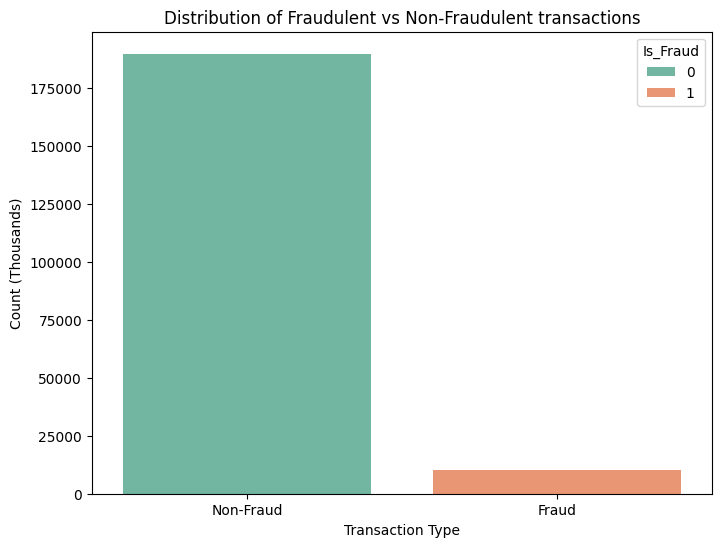

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(x='Is_Fraud', data=bank_df, palette='Set2', hue='Is_Fraud')
plt.title('Distribution of Fraudulent vs Non-Fraudulent transactions')
plt.xlabel('Transaction Type')
plt.ylabel('Count (Thousands)')
plt.xticks([0,1], ['Non-Fraud','Fraud'])
plt.show()


## **Distribution of Transaction Amounts**

This scatterplot can help assess if there's a relationship between the transaction amount and whether the transaction is fraudulent or not.

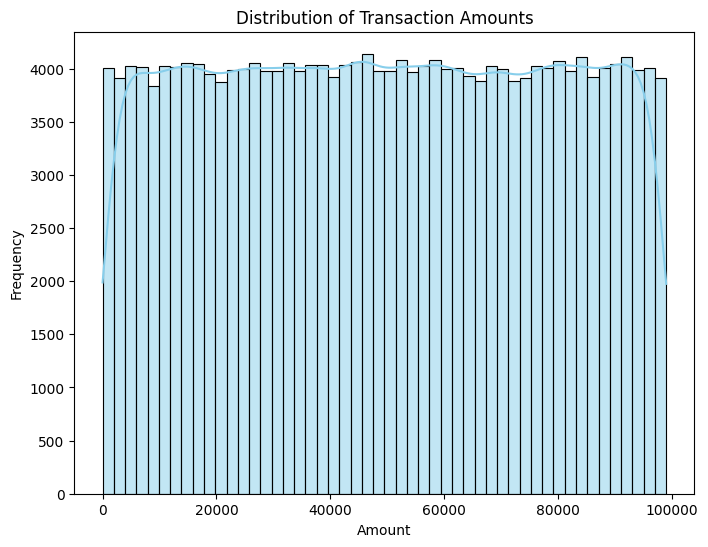

In [14]:
plt.figure(figsize=(8,6))
sns.histplot(bank_df['Transaction_Amount'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Transaction Amounts')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.show()


<ipython-input-15-23353bec0a7c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=bank_df, palette='Set2')


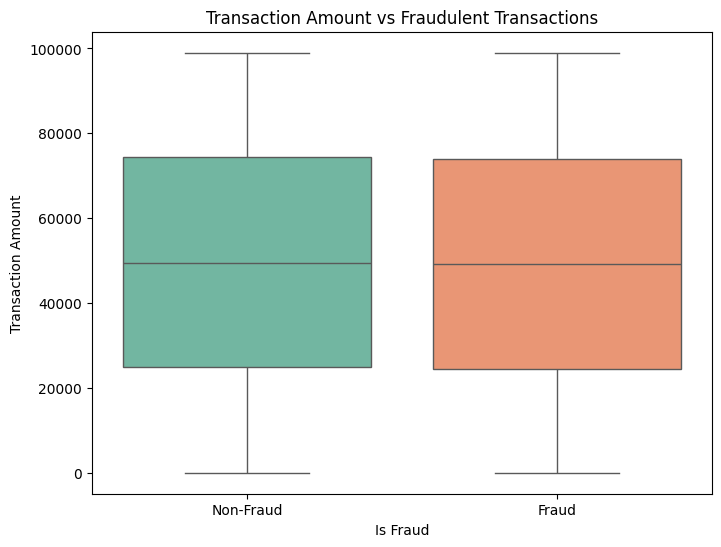

In [15]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Is_Fraud', y='Transaction_Amount', data=bank_df, palette='Set2')
plt.title('Transaction Amount vs Fraudulent Transactions')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.show()

## **Fraud by Transaction Type**

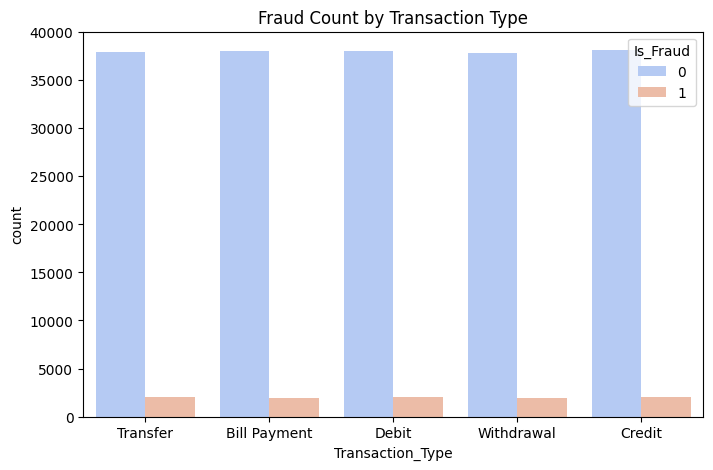

In [16]:
plt.figure(figsize=(8,5))
sns.countplot(data=bank_df, x='Transaction_Type', hue='Is_Fraud', palette='coolwarm')
plt.title("Fraud Count by Transaction Type")
plt.show()

## **Time-Based Analysis**

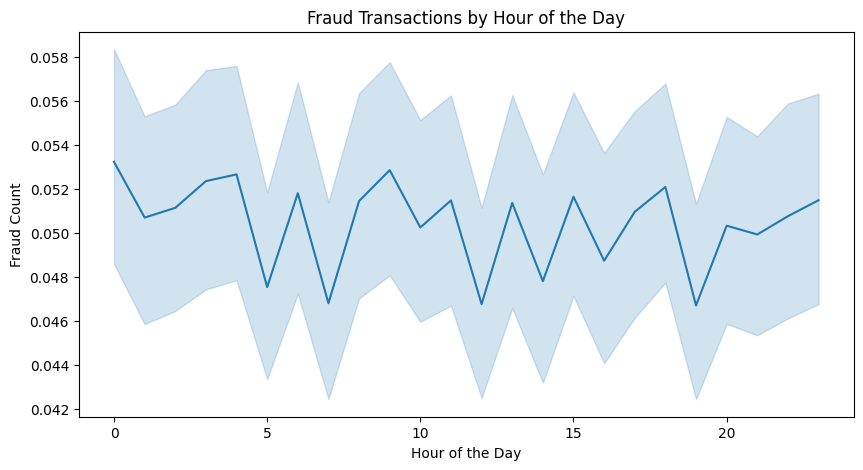

In [17]:
if 'Transaction_DateTime' in bank_df.columns:
    bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
    bank_df.set_index('Transaction_DateTime', inplace=True)
    bank_df['hour'] = bank_df.index.hour

    plt.figure(figsize=(10,5))
    sns.lineplot(x=bank_df['hour'], y=bank_df['Is_Fraud'])
    plt.title("Fraud Transactions by Hour of the Day")
    plt.xlabel("Hour of the Day")
    plt.ylabel("Fraud Count")
    plt.show()


## **Convert Datetime Features**

In [18]:
if 'Transaction_DateTime' in bank_df.columns:
    bank_df['Transaction_DateTime'] = pd.to_datetime(bank_df['Transaction_DateTime'])
    bank_df['Transaction_Hour'] = bank_df['Transaction_DateTime'].dt.hour
    bank_df['Transaction_Day'] = bank_df['Transaction_DateTime'].dt.dayofweek  # 0=Monday, 6=Sunday
    bank_df.drop(columns=['Transaction_date', 'Transaction_time'], inplace=True)  # Drop original timestamp


In [19]:
categorical_columns = bank_df.select_dtypes(include=['object']).columns.tolist()
print("Categorical Columns:", categorical_columns)

Categorical Columns: ['Gender', 'State', 'Bank_Branch', 'Account_Type', 'Transaction_ID', 'Merchant_ID', 'Transaction_Type', 'Merchant_Category', 'Transaction_Device', 'Transaction_Location', 'Device_Type', 'Transaction_Currency', 'Transaction_Description']


In [20]:
# Define feature matrix (X) and target variable (y)

X = bank_df.drop(columns=['Is_Fraud'])
y = bank_df['Is_Fraud']

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33, stratify=y)

## **Train a Classification Model**

## Baseline Model

I'll start by creating a baseline LogisticRegression model. I'll start by Standardizing the categorical columns and Numberical columns.

Once standaridized, I will create a pipeline that creates a baseline model.

In [21]:
print(y_train.value_counts(normalize=True))

Is_Fraud
0    0.949562
1    0.050438
Name: proportion, dtype: float64


### **Model the pipeline**

In [22]:
# Identify numerical & categorical columns
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(exclude=['object']).columns.tolist()

# Apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns),  # Categorical encoding
        ('num', StandardScaler(), numerical_columns)  # Scale numerical columns
    ],
    remainder='passthrough'  # Keep all columns not explicitly transformed
)

logreg_pipeline = Pipeline([
    ('preprocesson', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', class_weight='balanced', random_state=33))
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, zero_division=1))
# pipeline =

# # Fit and transform training data
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
# print(classification_report(y_test, y_pred, zero_division=1))

[[37982     0]
 [ 2018     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       1.00      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.97      0.50      0.49     40000
weighted avg       0.95      0.95      0.92     40000



/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


As shown earlier the dataset is imbalanced between counts that were considered to be fraudulent and counts that were not. Let's use XGBoost to address imblance. It's one of the best classifiers for this type of issue and works well for fraud detection

In [25]:
# Create XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(objective="binary:logistic",
                                  eval_metric="auc",
                                  scale_pos_weight=5,  # Increase this (try values between 5-10)
                                  use_label_encoder=True,
                                  random_state=33
                                 ))
])

# Define hyperparameters for tuning
xgb_params = {
    'classifier__n_estimators': [5,10],
    'classifier__max_depth': [3,6],
    'classifier__learning_rate': [0.01, 0.1]
}

#Grid Search for best parameters
xgb_grid = GridSearchCV(xgb_pipeline, xgb_params, cv=3, scoring='f1', n_jobs=-1)
xgb_grid.fit(X_train, y_train)

# Best Model Performance
y_pred_xgb = xgb_grid.best_estimator_.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred_xgb, zero_division=1))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:53:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[[37982     0]
 [ 2018     0]]
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37982
           1       1.00      0.00      0.00      2018

    accuracy                           0.95     40000
   macro avg       0.97      0.50      0.49     40000
weighted avg       0.95      0.95      0.92     40000



In [26]:
# Create Random Forest pipeline
'''Since RandomForestCLassifier is not as effective with imbalanced data, we will perform SMOTE on the target and see if we get better results.'''
# Wnsure y_train is a numpy Array
y_train = np.array(y_train)


# Apple preprocessing first
X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Count classes for SMOTE
subset_count = pd.Series(y_train).value_counts()
minority_count = subset_count[1]

# double the minory count
target_minority_count = minority_count * 2

# Apply SMOTE before Pipeline (Avoids data leakage)
smote = SMOTE(sampling_strategy={1: target_minority_count}, random_state=33)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_encoded, y_train)

# RandomForest Pipeline
rf_pipeline =  ImbPipeline([
    ('classifier', RandomForestClassifier(n_estimators=10,
                                          class_weight='balanced',
                                          random_state=33,
                                          max_depth=None))
])

rf_params = {
    'classifier__n_estimators': [5, 10],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2,5]
}

# Grisd Search for best parameters
rf_grid = GridSearchCV(rf_pipeline, rf_params, cv=3, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train_resampled, y_train_resampled)


# Ensure y_test is a Numpy Array
y_test = np.array(y_test)

# Evaluate best model
y_pred_rf = rf_grid.best_estimator_.predict(X_test_encoded)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=1))

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[[37756   226]
 [ 2007    11]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     37982
           1       0.05      0.01      0.01      2018

    accuracy                           0.94     40000
   macro avg       0.50      0.50      0.49     40000
weighted avg       0.90      0.94      0.92     40000



### Evaluating the Model on Test Data
Since we have an imbalanced classification probelm, accuracy is not enough to determine the models efficiency.

Let's print what precision, recall, and f1 provide.

In [27]:
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred_rf)}')
print(f'Precision: {precision_score(y_test, y_pred_rf)}')
print(f'Recall: {recall_score(y_test, y_pred_rf)}')
print(f'F1 Score: {f1_score(y_test, y_pred_rf)}')

ROC-AUC Score: 0.4997503772978061
Precision: 0.046413502109704644
Recall: 0.005450941526263627
F1 Score: 0.00975609756097561


In [28]:
print(f'Best Parameters: {rf_grid.best_params_}')
print(f'Best F1-Score: {rf_grid.best_score_}')

Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 5}
Best F1-Score: 0.48616756443971426


In [29]:
best_rf_model = rf_grid.best_estimator_.named_steps['classifier']
feature_importances = best_rf_model.feature_importances_

#get feature names
feature_name = preprocessor.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]

# # plot
# plt.figure(figsize=(10,6))
# plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
# plt.yticks(range(len(feature_importances)), np.array(feature_name)[sorted_idx])
# plt.xlabel('Feature Importance Score')
# plt.title('Random Forest Feature Importance')
# plt.gca().invert_yaxis()
# plt.show()


### Feature importance Analysis

Understanding what features drive fraud detection helps in model interpretability

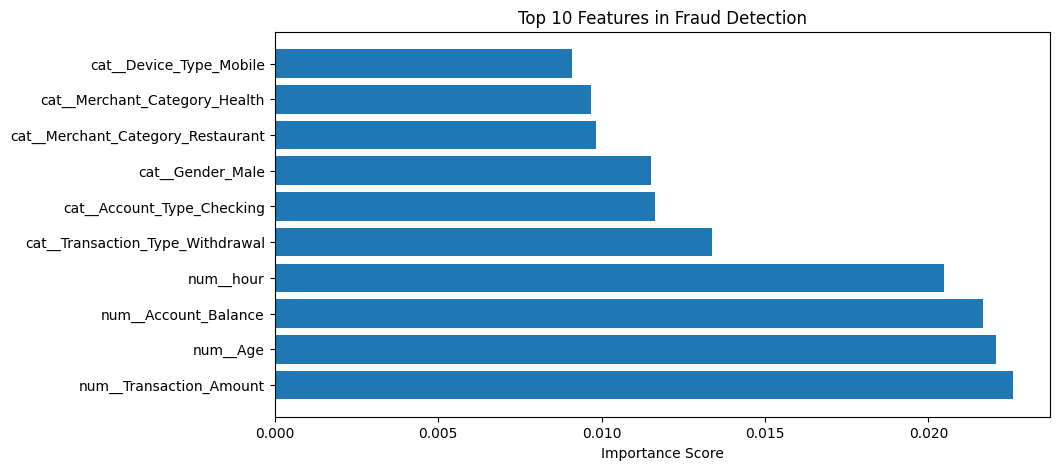

In [30]:
importances = rf_grid.best_estimator_.named_steps['classifier'].feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 5))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel("Importance Score")
plt.title("Top 10 Features in Fraud Detection")
plt.show()


In [31]:
# Define a simple neural network
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_resampled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['Precision', 'Recall', 'AUC'])

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predict
y_pred_nn = (model.predict(X_test) > 0.5).astype(int)

print("Neural Network F1 Score:", f1_score(y_test, y_pred_nn))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
5253/5253 ━━━━━━━━━━━━━━━━━━━━ 0s 501ms/step - AUC: 0.6532 - Precision: 0.5200 - Recall: 0.0874 - loss: 0.2982

ValueError: Invalid dtype: object

## **Time series Forecasting**

Let's split the dataset by time rather than randomly.

In [ ]:
bank_df = bank_df.sort_values(by='Transaction_DateTime')  # Ensure data is in time order


In [ ]:
train_size = int(0.8 * len(bank_df))
train, test = bank_df.iloc[:train_size], bank_df.iloc[train_size:]

X_train_time, y_train_time = train.drop(columns=['is_fraud']), train['is_fraud']
X_test_time, y_test_time = test.drop(columns=['is_fraud']), test['is_fraud']


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Esure 'Transaction_DATETIME column is set to index
bank_df.set_index('Transaction_DateTime', inplace=True)

#Aggregate fraud counts over time
fraud_counts = bank_df.resample('D')['Is_Fraud'].sum()

# Train ARIMA model
model = ARIMA(fraud_counts[:train_size], order=(5,1,0))
model_fit = model.fit()

# forecast future fraud cases
forecast = model_fit.forecast(steps=len(test))

# plot results
plt.figure(figsize=(10,5))
plt.plot(fraud_counts, label='Actual Fraud Cases')
plt.plot(test.index, forecast, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Fraud Prediction using Arima')
plt.show()